# 训练一个分类器

### 对于输入的数据
    一般来说, 当你不得不处理图像, 文本, 音频或者视频数据时, 你可以使用标准的 Python 包将数据加载到一个 numpy 数组中. 然后你可以将这个数组转换成一个 torch.*Tensor.
-    对于图像, 会用到的包有 Pillow, OpenCV .
-    对于音频, 会用的包有 scipy 和 librosa.
-    对于文本, 原始 Python 或基于 Cython 的加载, 或者 NLTK 和 Spacy 都是有用的.


### 训练一个图像分类器
1. 加载 CIFAR10 测试和训练数据集并规范化 torchvision
2. 定义一个卷积神经网络
3. 定义一个损失函数
4. 在训练数据上训练网络
5. 在测试数据上测试网络

### 1. 加载并规范化 CIFAR10

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

train_set=torchvision.datasets.CIFAR10(
    root='./cifar10',
    train=True,
    download=True,
    transform=transform
)
trainloader=torch.utils.data.DataLoader(
    train_set,
    batch_size=4,
    shuffle=True,
    num_workers=2
)
test_set=torchvision.datasets.CIFAR10(
    root='./cifar10',
    train=False,
    download=True,
    transform=transform
)
testloader = torch.utils.data.DataLoader(
    test_set,
    batch_size=4,
    shuffle=False,
    num_workers=2
)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# 进行一些数据的展示
import matplotlib.pyplot as plt
import numpy as np

 ship plane truck   car


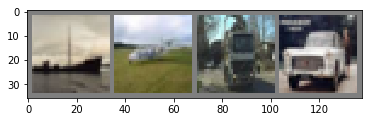

In [4]:
# 定义函数来显示图像


def imshow(img):
    img = img / 2 + 0.5     # 非标准化
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# 得到一些随机的训练图像
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 显示图像
imshow(torchvision.utils.make_grid(images))
# 输出类别
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### 2. 定义一个卷积神经网络

In [5]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()  #  >>>>>>>>>3X32X32
        self.conv1=nn.Conv2d(3,6,5)  # 输入的通道数是3,输出的通道数是6,卷积核大小为5*5;>>>>>6X28X28
        self.pool=nn.MaxPool2d(2,2)  # 池化层的核是2X2的,步长也为2 >>>>>>6X14X14
        self.conv2=nn.Conv2d(6,16,5)  # >>>>>>>16X10X10
        self.fc1=nn.Linear(16*5*5,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)
    
    def forward(self,x):  #  >>>>>>>>>3X32X32
        x=self.pool(F.relu(self.conv1(x)))  # >>>>>>>>>6X14X14
        x=self.pool(F.relu(self.conv2(x)))  # >>>>>>>>>16X5X5
        x=x.view(-1,16*5*5)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x

net=Net()

In [7]:
net

Net(
  (conv1): Conv2d (3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d (6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120)
  (fc2): Linear(in_features=120, out_features=84)
  (fc3): Linear(in_features=84, out_features=10)
)

### 3.定义损失函数和优化器
- 这里使用了交叉熵损失函数和随机梯度下降优化器

In [8]:
import torch.optim as optim

criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(net.parameters(),lr=0.001,momentum=0.9)

### 4.训练网络

In [9]:
import time
start_time=time.time()
for epoch in range(2):
    running_loss=0.0
    for i,data in enumerate(trainloader,0):
        # 得到输入数据
        inputs,labels=data
        # 包装数据
        inputs,labels=Variable(inputs),Variable(labels)
        # 梯度清零
        optimizer.zero_grad()
        
        # forward+backward+optimize
        outputs=net(inputs)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        
        # 打印消息
        running_loss+=loss.data[0]
        if i%2000 ==1999:
            print('[%d,%5d] loss: %.3f'%(epoch+1,i+1,running_loss/2000))
            running_loss=0.0
    
print('Finished Training')
end_time=time.time()
print('Training time:',end_time-start_time)

[1, 2000] loss: 2.173
[1, 4000] loss: 1.872
[1, 6000] loss: 1.689
[1, 8000] loss: 1.611
[1,10000] loss: 1.535
[1,12000] loss: 1.468
[2, 2000] loss: 1.402
[2, 4000] loss: 1.367
[2, 6000] loss: 1.336
[2, 8000] loss: 1.321
[2,10000] loss: 1.303
[2,12000] loss: 1.296
Finished Training
Training time: 75.86148166656494


### 5.在测试集上测试网络

GroundTruth:   cat  ship  ship plane


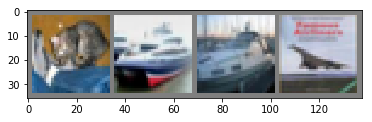

In [10]:
dataiter=iter(testloader)
images,labels=dataiter.next()

# 打印图像
imshow(torchvision.utils.make_grid(images))
print('GroundTruth:',' '.join('%5s'%classes[labels[j]] for j in range(4)))

In [11]:
outputs=net(Variable(images))

In [12]:
outputs

Variable containing:
-0.8067 -2.1248  1.3790  2.6742 -0.5098  1.9358  0.1349  0.4763 -1.2958 -1.3154
 4.5784  5.2780 -1.8617 -3.7609 -2.0521 -4.8995 -4.0237 -2.7827  5.5870  5.2058
 3.5960  2.9723 -0.7472 -2.2956 -1.2170 -3.8536 -2.8810 -2.0604  4.4359  1.9432
 3.4736  0.8851 -0.2017 -1.3305 -0.5753 -3.4730 -2.7957 -2.3136  5.1021  0.8231
[torch.FloatTensor of size 4x10]

In [13]:
_,predicted=torch.max(outputs.data,1)  # 该函数得到张量在给定维度dim上的最大值,1为在每一行的最大值,0为在每一列的,
                                       # 返回该张量最大值及该值的位置索引
print(_) # 最大值
print('---------------') 
print(predicted)  # 最大值位置索引
print('Predicted:',' '.join('%5s'% classes[predicted[j]] for j in range(4)))  # 结果集的每一列代表一张图片在10个输出
                                                                              # 结果中的相似度,最大值代表最像某类图片,
                                                                              # 取出其索引去对应每个分类


 2.6742
 5.5870
 4.4359
 5.1021
[torch.FloatTensor of size 4]

---------------

 3
 8
 8
 8
[torch.LongTensor of size 4]

Predicted:   cat  ship  ship  ship


In [14]:
# 在整个测试集上的效果
correct=0
total=0
for data in testloader:
    images,labels=data  # 每次遍历得到的是数据集批训练个数的集合
    outputs=net(Variable(images))
    _,predicted=torch.max(outputs.data,1)
    total+=labels.size(0)
    correct+=(predicted==labels).sum()
print('Accuracy of the network on the 10000 test images:%d %%'%(100*correct/total))

Accuracy of the network on the 10000 test images:55 %
